## External Preference Mapping (EPM) with Simulated Chocolate Data  

This notebook shows how **External Preference Mapping (EPM)** can be implemented in Python to relate *product sensory profiles* to simulated *consumer product liking* data. EPM combines Descriptive Analysis (DA) results with consumer preference scores and is often analyzed using Partial Least Squares Regression (PLS-R) (Drake, Watson, & Liu, *Annual Review of Food Science and Technology*, 2024).  

This notebook demonstrates a sensory data workflow, from simulation and preprocessing to preference modeling with PLS-R. 

- I start with the *sensochoc* example from the R package [`sensehubr`](https://github.com/aswansyahputra/sensehubr), and extend it by creating additional synthetic chocolate profiles in Python, yielding fifty total products.

- I then simulate consumer liking data (including age-related effects), preprocesses the sensory features through mean-centering, and fit two PLS-R models: one based on a linear liking function and one based on a non-linear liking function to explore how PLS-R performs in each scenario.

### Business Relevance

Sensory science often seeks to link data from trained sensory panels to consumer preferences.

Here, we show how the statistical technique PLS-R can help visualize and predict relationships between these two types of data.

This approach can inform why consumers may like a product and highlight which features are most likely to optimize new products.

---

## Setup and Data Import

Here we import the Python libraries used in the analysis and read in the observed chocolate data.

In [3]:
# libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error

# project root
repo_root = Path().resolve().parent
sys.path.insert(0, str(repo_root))   # add project root to sys.path

# sensory data path
CSV_PATH = repo_root / "data" / "sensochoc_dataset.csv"
assert CSV_PATH.exists(), f"CSV file not found: {CSV_PATH}"

# read sensory data
df_original = pd.read_csv(CSV_PATH)

# view sensory data
display(df_original)

,Unnamed: 0,panelist,session,rank,product,cocoa_a,milk_a,cocoa_f,milk_f,caramel,vanilla,sweetness,acidity,bitterness,astringency,crunchy,melting,sticky,granular
0,1,id_001,session_01,order_01,choc6,7,6,6,5,5,3,7,2,4,5,8,3,4,3
1,2,id_001,session_01,order_06,choc3,6,7,2,7,8,4,7,2,2,3,3,8,6,5
2,3,id_001,session_01,order_03,choc2,8,6,5,4,7,4,5,5,6,6,7,5,4,3
3,4,id_001,session_01,order_05,choc1,7,8,8,3,3,2,4,7,8,6,3,2,3,5
4,5,id_001,session_01,order_02,choc4,8,5,4,4,4,4,5,6,6,4,6,3,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,344,id_029,session_02,order_04,choc5,5,7,9,6,2,0,2,1,7,6,1,8,0,0
344,345,id_029,session_02,order_03,choc2,1,2,8,2,1,0,3,6,5,5,9,3,0,0
345,346,id_029,session_02,order_01,choc6,8,3,8,1,1,0,6,1,5,3,7,7,1,0
346,347,id_029,session_02,order_02,choc4,3,7,3,5,7,4,6,0,2,1,1,7,0,0


---

## Sensory Data Preprocessing

This section describes several preprocessing steps taken to obtain a dataset containing sensory descriptors for 50 unique chocolate products.

We begin with six chocolate types from the *sensochoc* dataset and generate 44 additional synthetic products using a multivariate sampling approach based on the original data’s means and covariance structure.

### Sensochoc Data

To estimate the sensory profile of each of the six observed chocolate types, we aggregate the *sensochoc* data in two steps:

1) The 14 ratings provided by each participant will be averaged across the two timepoints
2) The averaged ratings for the 29 panelists will be averaged across each chocolate type

These steps create a dataframe with **one row for each of the 6 chocolates**, which is suitable for PLS-R analysis.

In [4]:
# column names of sensory descriptors
cols = ['cocoa_a','milk_a','cocoa_f','milk_f','caramel','vanilla','sweetness',
        'acidity','bitterness','astringency','crunchy','melting','sticky','granular']

# aggregate across time points (average the two per panelist × product)
df_panelist_product = df_original.groupby(['panelist','product'], as_index=False)[cols].mean()

# aggregate across panelists (average the 29 panelists for each product)
df_product = df_panelist_product.groupby(['product'], as_index=False)[cols].mean()

# zero-pad strings for subsequent ordering
df_product['product'] = [f"choc{i+1:02d}" for i in range(df_product.shape[0])]

# check
print("Any NaNs?", df_original[cols].isna().any().any())
print("Original rows:", df_original.shape[0])
print("Rows after avg across timepoints:", df_panelist_product.shape[0])
print("Rows after avg across panelists:", df_product.shape[0])
display(df_product)

Any NaNs? False
Original rows: 348
Rows after avg across timepoints: 174
Rows after avg across panelists: 6


,product,cocoa_a,milk_a,cocoa_f,milk_f,caramel,vanilla,sweetness,acidity,bitterness,astringency,crunchy,melting,sticky,granular
0,choc01,7.086207,3.586207,8.068966,1.568966,1.672414,1.103448,3.137931,4.655172,7.068966,4.758621,5.965517,4.741379,3.758621,3.448276
1,choc02,6.551724,4.000000,6.913793,2.379310,2.775862,1.810345,4.620690,3.137931,4.948276,3.155172,7.706897,4.327586,3.827586,3.155172
2,choc03,4.672414,6.051724,3.379310,7.706897,6.327586,3.672414,7.603448,1.568966,1.396552,1.206897,2.982759,7.310345,5.034483,1.603448
3,choc04,6.258621,4.103448,6.689655,2.586207,2.672414,2.120690,4.293103,3.931034,5.189655,3.689655,6.103448,4.379310,4.103448,3.551724
4,choc05,6.793103,4.172414,6.793103,3.120690,3.413793,1.793103,5.224138,3.086207,4.879310,3.103448,6.637931,4.741379,3.224138,3.068966
5,choc06,6.362069,4.568966,6.224138,3.362069,3.258621,1.913793,5.620690,2.672414,4.189655,2.758621,7.327586,4.206897,3.931034,3.172414


### Synthetic Product Generation

Because the *sensochoc* dataset includes only six chocolate types, it is too small for PLS-R to be used as more than a descriptive tool (i.e., to visualize trends).

To allow for model estimation and validation, we expand the dataset by generating synthetic sensory profiles using a covariance matrix derived from the empirical data (with regularization to help with numerical stability).

This approach preserves the multivariate relationships among the sensory descriptors while increasing the sample size by 44 simulated products.

In [19]:
# create X_df with product as index
X_df = df_product.set_index('product')

# get mean and covariance of X_df
mu = X_df.mean(axis=0).values
cov = X_df.cov().values

# set seed for reproduciblity
np.random.seed(7)

# generate synthetic chocolate types
n_extra_rows = 44                             # to reach 50
eps = 1e-4 * np.trace(cov) / cov.shape[0]     # add some variance
cov_reg = cov + eps * np.eye(cov.shape[0])    # regularize covariance to help with small sample size
X_synth = np.random.multivariate_normal(mu, cov_reg, size=n_extra_rows)    # generate synthetic data
X_all = np.vstack([X_df.values, X_synth])     # bind observed and synthetic data by row
product_index = list(X_df.index) + [f"choc{i+7:02d}" for i in range(n_extra_rows)] # generate names for the synthetic data
X_all_df = pd.DataFrame(X_all, columns=X_df.columns, index=product_index) # organize data into dataframe with 'product' as the index 

# check
display(X_all_df.head(10)) # showing first 10 cases; first 6 rows are observed cases; the remaining rows are simulated cases

,cocoa_a,milk_a,cocoa_f,milk_f,caramel,vanilla,sweetness,acidity,bitterness,astringency,crunchy,melting,sticky,granular
choc01,7.086207,3.586207,8.068966,1.568966,1.672414,1.103448,3.137931,4.655172,7.068966,4.758621,5.965517,4.741379,3.758621,3.448276
choc02,6.551724,4.000000,6.913793,2.379310,2.775862,1.810345,4.620690,3.137931,4.948276,3.155172,7.706897,4.327586,3.827586,3.155172
choc03,4.672414,6.051724,3.379310,7.706897,6.327586,3.672414,7.603448,1.568966,1.396552,1.206897,2.982759,7.310345,5.034483,1.603448
choc04,6.258621,4.103448,6.689655,2.586207,2.672414,2.120690,4.293103,3.931034,5.189655,3.689655,6.103448,4.379310,4.103448,3.551724
choc05,6.793103,4.172414,6.793103,3.120690,3.413793,1.793103,5.224138,3.086207,4.879310,3.103448,6.637931,4.741379,3.224138,3.068966
choc06,6.362069,4.568966,6.224138,3.362069,3.258621,1.913793,5.620690,2.672414,4.189655,2.758621,7.327586,4.206897,3.931034,3.172414
choc07,4.897124,5.804070,3.680699,7.016935,6.086887,3.552235,7.610903,1.358214,1.348829,1.047733,4.424749,6.599511,4.720751,1.830541
choc08,6.465897,4.272590,6.552201,2.748411,2.963161,1.908671,5.236321,2.816215,4.434600,2.828533,7.957925,3.912515,3.797573,3.345639
choc09,5.538521,5.141632,4.847953,5.603971,5.202048,2.961940,6.651075,1.890769,2.578547,1.676537,5.269973,6.210290,4.254390,2.054317
choc10,6.278929,4.887440,5.631436,4.738459,4.567278,2.276784,6.576349,2.241220,3.479366,2.241483,5.948782,5.225877,3.437936,2.692123


---
### Simulated Liking Data Preprocessing

The goal of this exercise is to explore the usage of PLS-R with the sensory data combined with product liking ratings from consumers. 
Because the *sensochoc* dataset does not contain such consumer information, we will simulate liking ratings in two ways:  

- **Linear liking** modeled as a simple linear combination of the sensory attributes, where sweetness, bitterness, and astringency contribute additively
- **Non-linear liking** modeled age-dependent preference shifts and a non-linear response to extreme sweetness

To control for individual differences in rating behavior, we also mean-center the raw liking ratings per person.

In [25]:
from scripts.liking_linear import linear_liking
from scripts.liking_nonlinear import nonlinear_liking

# set seed for reproduciblity
np.random.seed(42)

# person-level data
n_persons = 300
ages = np.round(np.clip(np.random.normal(42, 13, size=n_persons), 18, 75))
pids = np.arange(1, n_persons + 1)      

# product series
product = [f"choc{i:02d}" for i in range(1, 51)]

# nested loop to simulate data
results = []
for pid, age in zip(pids, ages):
    for prod in product:
        l_liking = linear_liking(prod, age, X_df = X_all_df)
        nl_liking = nonlinear_liking(prod, age, X_df = X_all_df)
        results.append((pid, age, prod, l_liking, nl_liking))

# result
y_df = pd.DataFrame(results, columns=["person_id","age", "product", "l_liking", "nl_liking"])

# rescale to remove negative values
abs_min_l_liking = abs(min(y_df['l_liking']))
y_df['l_liking'] = y_df['l_liking'] + abs_min_l_liking + 0.5

abs_min_nl_liking = abs(min(y_df['nl_liking']))
y_df['nl_liking'] = y_df['nl_liking'] + abs_min_nl_liking + 0.5

# center liking scores by individual
y_df["l_liking_centered"] = y_df["l_liking"] - y_df.groupby("person_id")["l_liking"].transform("mean")
y_df["nl_liking_centered"] = y_df["nl_liking"] - y_df.groupby("person_id")["nl_liking"].transform("mean")

# create string version of person_id that pads with zeros for sorting
y_df['person_id_str'] = y_df['person_id'].apply(lambda x: f"id_{x:03d}")

# check
display(y_df)

,person_id,age,product,l_liking,nl_liking,l_liking_centered,nl_liking_centered,person_id_str
0,1,48.0,choc01,2.866353,26.730564,-2.724192,-1.914277,id_001
1,1,48.0,choc02,5.564842,29.271013,-0.025703,0.626171,id_001
2,1,48.0,choc03,8.482468,28.164146,2.891923,-0.480696,id_001
3,1,48.0,choc04,5.462786,27.461421,-0.127759,-1.183421,id_001
4,1,48.0,choc05,5.804399,28.752662,0.213854,0.107820,id_001
...,...,...,...,...,...,...,...,...
14995,300,50.0,choc46,5.506823,28.331647,0.085198,-0.263982,id_300
14996,300,50.0,choc47,8.257453,29.156385,2.835828,0.560756,id_300
14997,300,50.0,choc48,4.605952,28.836473,-0.815673,0.240844,id_300
14998,300,50.0,choc49,8.105497,28.702662,2.683872,0.107033,id_300


Here we visualize the simulated liking ratings as a quick sanity check.

The histograms below show the distributions of the linear and non-linear liking ratings, as well as consumer age.

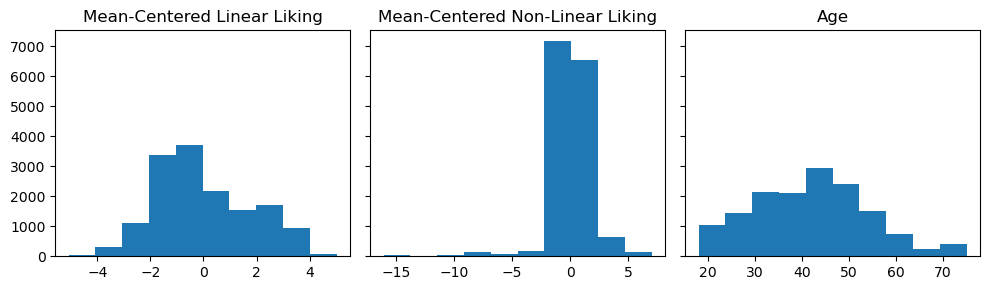

In [26]:
# visualize liking_centered scores and age
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10, 3))

# histogram for mean-centered linear liking
axs[0].hist(y_df['l_liking_centered'], bins= 10)
axs[0].set_title("Mean-Centered Linear Liking")

# histogram for mean-centered non-linear liking
axs[1].hist(y_df['nl_liking_centered'], bins= 10)
axs[1].set_title("Mean-Centered Non-Linear Liking")

# histogram of age distribution
axs[2].hist(y_df['age'], bins= 10) # be aware there are 50 replicates per person in this chart
axs[2].set_title("Age")

plt.show()

Here we pivot the linear liking ratings into a wide table appropriate for PLS-R analysis.

In [27]:
# spread linear liking across person_id
y_l_df = y_df.pivot(index='product',columns='person_id_str',values='l_liking_centered')
y_l_df.head(5)

person_id_str,id_001,id_002,id_003,id_004,id_005,id_006,id_007,id_008,id_009,id_010,...,id_291,id_292,id_293,id_294,id_295,id_296,id_297,id_298,id_299,id_300
product,,,,,,,,,,,,,,,,,,,,,
choc01,-2.724192,-3.036942,-1.743985,-1.841612,-2.456612,-1.906263,-2.058939,-1.726055,-1.839178,-2.159225,...,-2.255660,-1.575183,-2.084767,-2.740923,-2.153087,-1.770646,-2.292975,-3.160943,-1.976360,-3.509162
choc02,-0.025703,-0.326761,-0.996013,0.125041,-0.637078,-0.417000,-0.318558,-0.485572,0.616349,-0.250344,...,-1.016187,-0.482095,-0.943706,-0.533883,-0.417313,-0.495111,0.303548,-0.553827,-1.207524,-0.391032
choc03,2.891923,2.747308,2.679674,3.198680,2.238504,2.619416,3.064343,3.135448,3.427977,3.014662,...,4.029941,2.699771,3.821184,3.403475,3.029085,3.645928,2.136618,3.553493,3.068840,3.408412
choc04,-0.127759,-1.230435,-0.960167,-1.063897,-1.292362,-0.721234,-1.380100,-0.435032,-0.488693,-1.029730,...,-0.063609,-1.046525,-0.635590,-1.697175,-0.346828,-0.821068,-1.512274,-1.217216,-0.155986,-0.419259
choc05,0.213854,0.070420,0.067187,-0.859466,-0.986216,0.502473,0.329467,0.349044,-0.400068,-0.673140,...,0.020881,0.118883,0.405277,0.041192,-0.170926,-0.986336,0.320098,0.117530,0.640272,-0.441924


Here we pivot the non-linear liking ratings into a wide table appropriate for PLS-R analysis.

In [28]:
# spread non-linear liking across person_id
y_nl_df = y_df.pivot(index='product',columns='person_id_str',values='nl_liking_centered')
y_nl_df.head(5)

person_id_str,id_001,id_002,id_003,id_004,id_005,id_006,id_007,id_008,id_009,id_010,...,id_291,id_292,id_293,id_294,id_295,id_296,id_297,id_298,id_299,id_300
product,,,,,,,,,,,,,,,,,,,,,
choc01,-1.914277,-1.840997,-0.559954,-2.102112,-1.111126,-1.948308,-1.818289,-1.109167,-3.054078,-1.875563,...,-2.445684,-1.684017,-1.629951,-0.957202,-1.531366,-2.152634,-1.739417,-2.049694,-1.530968,-1.603921
choc02,0.626171,0.437353,0.721995,0.991962,-0.384689,0.033749,0.972778,0.060220,0.279427,0.565961,...,0.659132,-0.631395,0.122929,0.177966,0.311609,0.299327,0.356058,0.507806,0.451682,0.060951
choc03,-0.480696,-0.135057,-0.663397,0.392196,-0.237798,-0.750045,-0.503574,-0.279914,-1.031076,-0.545737,...,0.199447,-0.901729,-0.309490,-0.221088,-1.069976,-1.617590,-0.782380,-0.080306,-0.356275,-0.132716
choc04,-1.183421,-0.865947,-1.200106,-1.516805,-0.011682,-1.183109,-0.501942,-0.507346,-1.386106,-1.245759,...,-0.587922,-0.697744,-0.177330,-1.125350,-1.208952,-1.050512,-0.928318,-0.961506,-1.087678,-0.319476
choc05,0.107820,0.559013,-0.087034,0.950096,1.055701,-0.294486,1.303111,0.004002,1.194169,1.057031,...,-0.177976,-0.448258,0.189223,-0.187431,0.491753,-0.002739,-0.044835,0.189799,-0.364385,0.031303


---
## Linear Liking PLS-R Analysis

We perform PLS-R using the sensory data with the liner liking ratings. First we split the data into training and test sets.

In [29]:
# assign sensory data to predictors (X) and linear liking to (y)
X = X_all_df
y = y_l_df

In [30]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=17)

## Model Selection

Next, we use **5-Fold Cross-Validation** on the training data to determine the optimal number of components for the PLS-R analysis.

For each candidate number of components, we compute the mean squared error (MSE) using cross-validation. 

The lowest MSE is observed at n_components = 2, which indicates that a two-component model is the best choice for these data.

(-1.0, 13.6)

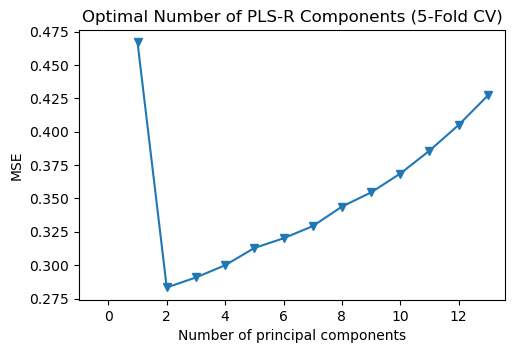

In [31]:
n = len(X_train)

# 5-fold CV
kf_5 = KFold(n_splits=5, shuffle=True, random_state=18)

mse = []

for i in np.arange(1, 14):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, X_train, y_train, cv=kf_5, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.figure(figsize=(5.5,3.5)) 
plt.plot(np.arange(1, 14), np.array(mse), '-v')
plt.xlabel('Number of principal components')
plt.ylabel('MSE')
plt.title('Optimal Number of PLS-R Components (5-Fold CV)')
plt.xlim(xmin=-1)

## Model Evaluation

Next, we fit the full model on the training data and evaluate its performance on the test set.

In [32]:
# initialize PLS-R model
n_components = 2 
pls_model = PLSRegression(n_components= n_components)

# fit the model on the training data
pls_model.fit(X_train, y_train)

,n_components,2
,scale,True
,max_iter,500
,tol,1e-06
,copy,True


In [34]:
# predictions on the test set
y_pred = pls_model.predict(X_test)

# Evaluate the model performance
r_squared = pls_model.score(X_test, y_test)
print(f"R-Squared Error: {r_squared}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

R-Squared Error: 0.8247709476425825
Mean Squared Error: 0.27443578456246653


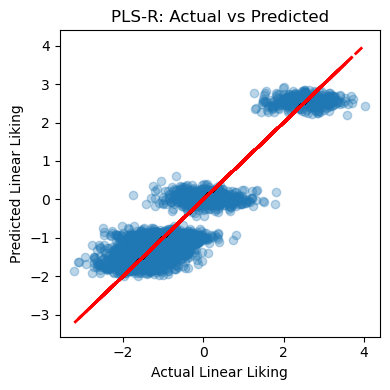

In [35]:
# scatterplot
plt.figure(figsize=(4,4))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)  # y=x line
plt.xlabel("Actual Linear Liking")
plt.ylabel("Predicted Linear Liking")
plt.title("PLS-R: Actual vs Predicted")
plt.tight_layout()
plt.show()

### Model Evaluation Interpretation

- The PLS-R model explains much of the variance in the test data (R² ≈ 0.83).
- The MSE (0.27) is small relative to the range of liking scores (-5 to 5), indicating the model predictions are close to the observed values.
- The actual vs predicted plot suggests three distinct clusters, likely corresponding to groups of chocolate types with similar sensory profiles. 
- The model predicts the relative differences between these clusters well, even if individual variability within clusters is less precisely captured.

Overall, the model predicts consumer liking ratings well, supporting the validity of using PLS-R on these sensory data.

Next we will visualize the model's biplot.

As expected from the simulation design, the linear liking scores align strongly with sweetness and show negative correlations with bitterness and astringency.

In [36]:
# prepare data from biplot
X = X_all_df.copy()
y = y_l_df.copy()
if 'person_id_str' in y.columns:
    y = y.drop(columns='person_id_str')

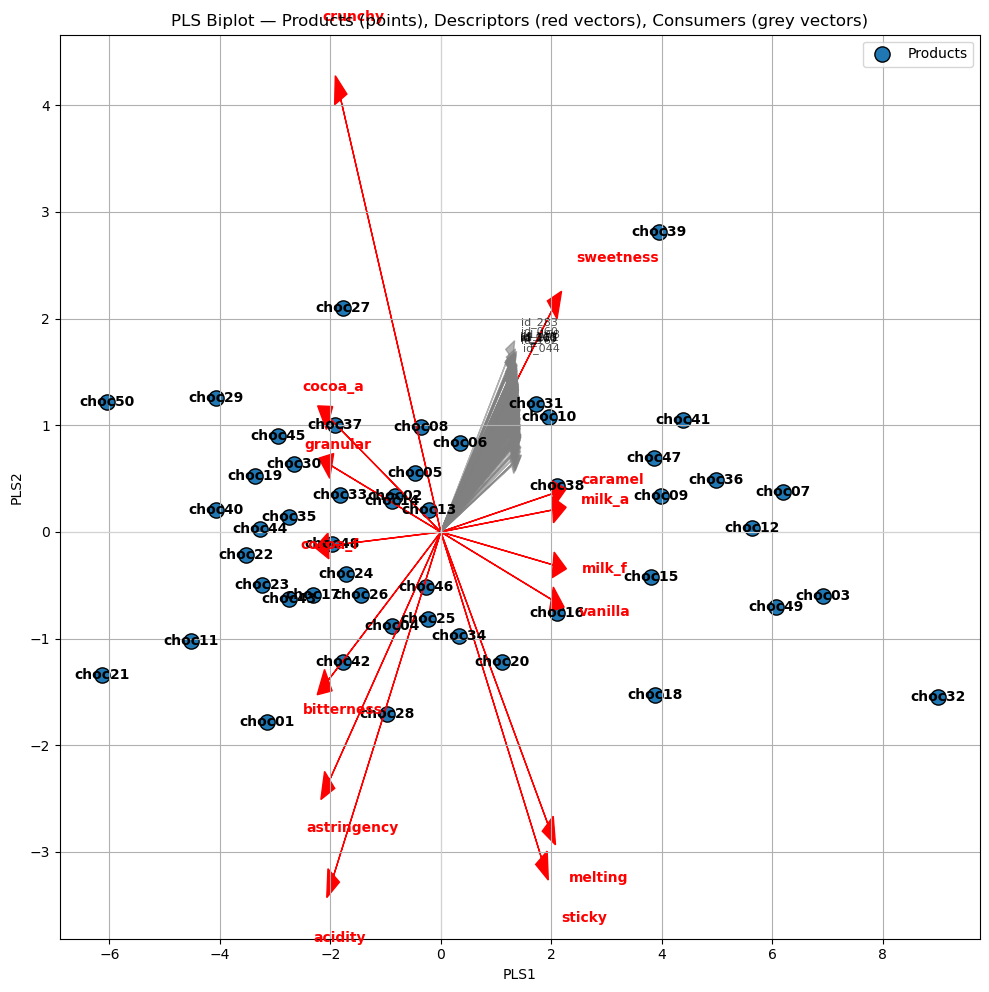

In [37]:
# generate the biplot
%run ../scripts/chocolate_biplot.py

plot_pls_biplot(X, y, n_components=2, top_consumers=300)

## Key Findings (Linear Liking)

- The PLS‑R model explained ~83% of variance in simulated linear liking scores.
- As expected, sweetness had the strongest positive loading; bitterness and astringency loaded negatively.

---

## Non-Linear Liking PLS-R Analysis

We perform PLS-R using the sensory data with the non-liner liking ratings. First we split the data into training and test sets.

In [38]:
# assign sensory data to predictors (X) and linear liking to (y)
X = X_all_df
y = y_nl_df

In [39]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=18)

### Model Selection

As before, next we use **5-Fold Cross-Validation** on the training data to determine the optimal number of components for the PLS-R analysis.

For each candidate number of components, we compute the mean squared error (MSE) using cross-validation. 

The lowest MSE is observed at n_components = 2.

(-1.0, 13.6)

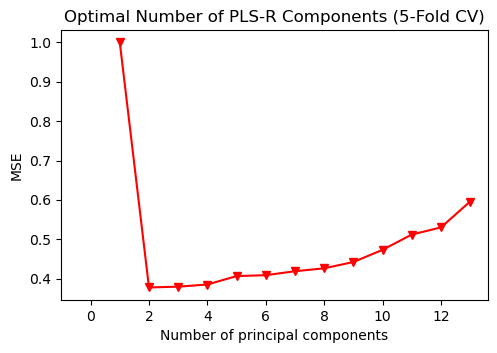

In [41]:
n = len(X_train)

# 5-fold CV
kf_5 = KFold(n_splits=5, shuffle=True, random_state=17)

mse = []

for i in np.arange(1, 14):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, X_train, y_train, cv=kf_5, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.figure(figsize=(5.5,3.5)) 
plt.plot(np.arange(1, 14), np.array(mse), '-v', c = "r")
plt.xlabel('Number of principal components')
plt.ylabel('MSE')
plt.title('Optimal Number of PLS-R Components (5-Fold CV)')
plt.xlim(xmin=-1)

## Model Evaluation

Next, we fit the full model on the training data and evaluate its performance on the test set.

In [42]:
# initialize PLS-R model
n_components = 2
pls_model = PLSRegression(n_components= n_components)

# fit the model on the training data
pls_model.fit(X_train, y_train)

,n_components,2
,scale,True
,max_iter,500
,tol,1e-06
,copy,True


In [43]:
# predictions on the test set
y_pred = pls_model.predict(X_test)

# Evaluate the model performance
r_squared = pls_model.score(X_test, y_test)
print(f"R-Squared Error: {r_squared}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

R-Squared Error: 0.8111823165930588
Mean Squared Error: 0.5756255090915036


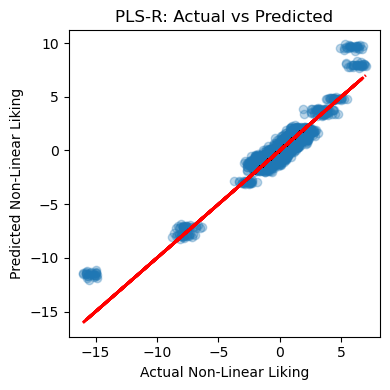

In [44]:
# scatterplot
plt.figure(figsize=(4,4))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)  # y=x line
plt.xlabel("Actual Non-Linear Liking")
plt.ylabel("Predicted Non-Linear Liking")
plt.title("PLS-R: Actual vs Predicted")
plt.tight_layout()
plt.show()

### Model Evaluation Interpretation

- The PLS-R model explains much of the variance in the test data (R² ≈ 0.81).
- The MSE (0.58) is small relative to the range of liking scores (-16 to 6), indicating the model predictions are close to the observed values.
- The actual vs predicted plot suggests the model does fairly well, especially near the mid-range scores.
- At the highest and lowest lining scores, however, there are large deviations between the predicted and actual values. This is expected, because these lining scores were simulated with a non-linear component.

Overall, PLS-R predicts liking well across most of the distribution, while underperforming at the extremes. This results is consistent with the PLS-R’s linear constraints.

In [46]:
# prepare data from biplot
X = X_all_df.copy()
y = y_nl_df.copy()
if 'person_id_str' in y.columns:
    y = y.drop(columns='person_id_str')

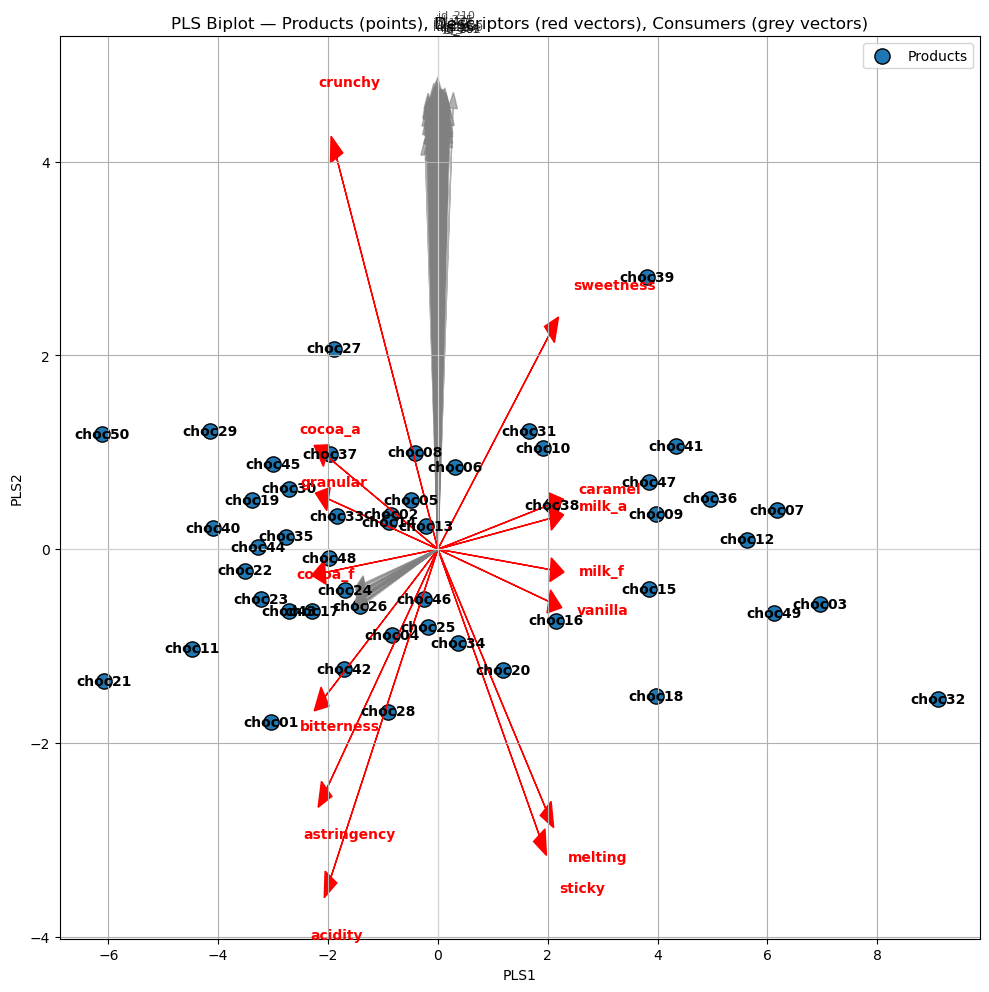

In [47]:
# generate the biplot
%run ../scripts/chocolate_biplot.py

plot_pls_biplot(X, y, n_components=2, top_consumers=300)

### Key Findings

- The PLS‑R model explained ~81% of variance in simulated non-linear liking scores.
- PLS-R models the linear component of the liking ratings well, but shows systematic underperformance at the extremes.

### Take Aways

- This simulation demonstrates how PLS-R can be used in to model the relationship of panel-collected sensory data with survey-collected consumer liking data, mirroring External Preference Mapping.
- PLS-R performed well when the simulated relationships were largely linear, but performance degraded at the extremes of the liking scale.
- The results make the practical point that PLS-R is useful for modeling linear relationships, but we should be more cautious in interpreting predictions where the relationships are non-linear.